In [1]:
#import os

#import gradio as gr
import numpy as np
import torch
from mobile_sam import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
# from PIL import ImageDraw
# from mobile_sam.utils.tools import box_prompt, format_results, point_prompt
from app.utils.tools_gradio import fast_process

# Most of our demo code is from [FastSAM Demo](https://huggingface.co/spaces/An-619/FastSAM). Huge thanks for AN-619.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\KU\ATIA\MobileSAM\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\KU\ATIA\MobileSAM\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarni

device(type='cuda')

In [2]:
# Load the pre-trained model
sam_checkpoint = "weights\mobile_sam.pt"
model_type = "vit_t"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam = mobile_sam.to(device=device)
mobile_sam.eval()

c:\KU\ATIA\MobileSAM\mobile_sam\build_sam.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
 

In [10]:
next( mobile_sam.mask_decoder.parameters())

Parameter containing:
tensor([[-0.0879, -0.1321,  0.0836,  ...,  0.0004, -0.0185,  0.0011],
        [-0.0375, -0.1283,  0.0036,  ...,  0.0273, -0.0380,  0.0483],
        [-0.0320,  0.0465,  0.0535,  ..., -0.0090, -0.0755,  0.1173],
        ...,
        [ 0.0465,  0.0303, -0.0648,  ...,  0.0008,  0.0163, -0.0158],
        [ 0.0622,  0.0186, -0.0068,  ...,  0.0297,  0.0375, -0.0383],
        [ 0.0084, -0.0070,  0.0405,  ..., -0.0055,  0.0015,  0.0230]],
       device='cuda:0', requires_grad=True)

In [3]:
mask_generator = SamAutomaticMaskGenerator(mobile_sam)
predictor = SamPredictor(mobile_sam)

In [4]:
examples = [
    ["assets/picture3.jpg"],
    ["assets/picture4.jpg"],
    ["assets/picture5.jpg"],
    ["assets/picture6.jpg"],
    ["assets/picture1.jpg"],
    ["assets/picture2.jpg"],
]

In [7]:
@torch.no_grad()
def segment_everything(
    image,
    input_size=1024,
    better_quality=False,
    withContours=True,
    use_retina=True,
    mask_random_color=True,
):
    global mask_generator

    input_size = int(input_size)
    w, h = image.size
    scale = input_size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    image = image.resize((new_w, new_h))

    nd_image = np.array(image)
    annotations = mask_generator.generate(nd_image)

    fig = fast_process(
        annotations=annotations,
        image=image,
        device=device,
        scale=(1024 // input_size),
        better_quality=better_quality,
        mask_random_color=mask_random_color,
        bbox=None,
        use_retina=use_retina,
        withContours=withContours,
    )
    return fig

In [18]:
from PIL import Image
image = Image.open('app/assets/picture4.jpg')
image = np.asarray(image)


In [19]:
predictor.set_image(image)


In [20]:
p = np.array([560,800]).reshape(1,2)
p = None

In [21]:
from app.utils.tools import box_prompt, format_results, point_prompt
masks, scores, logits = predictor.predict(p,point_labels= np.array([1]))
results = format_results(masks, scores, logits, 0)

In [8]:

#560/800
results[0]

{'id': 0,
 'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'bbox': [0, 0, 1816, 992],
 'score': 0.50623554,
 'area': 569243}

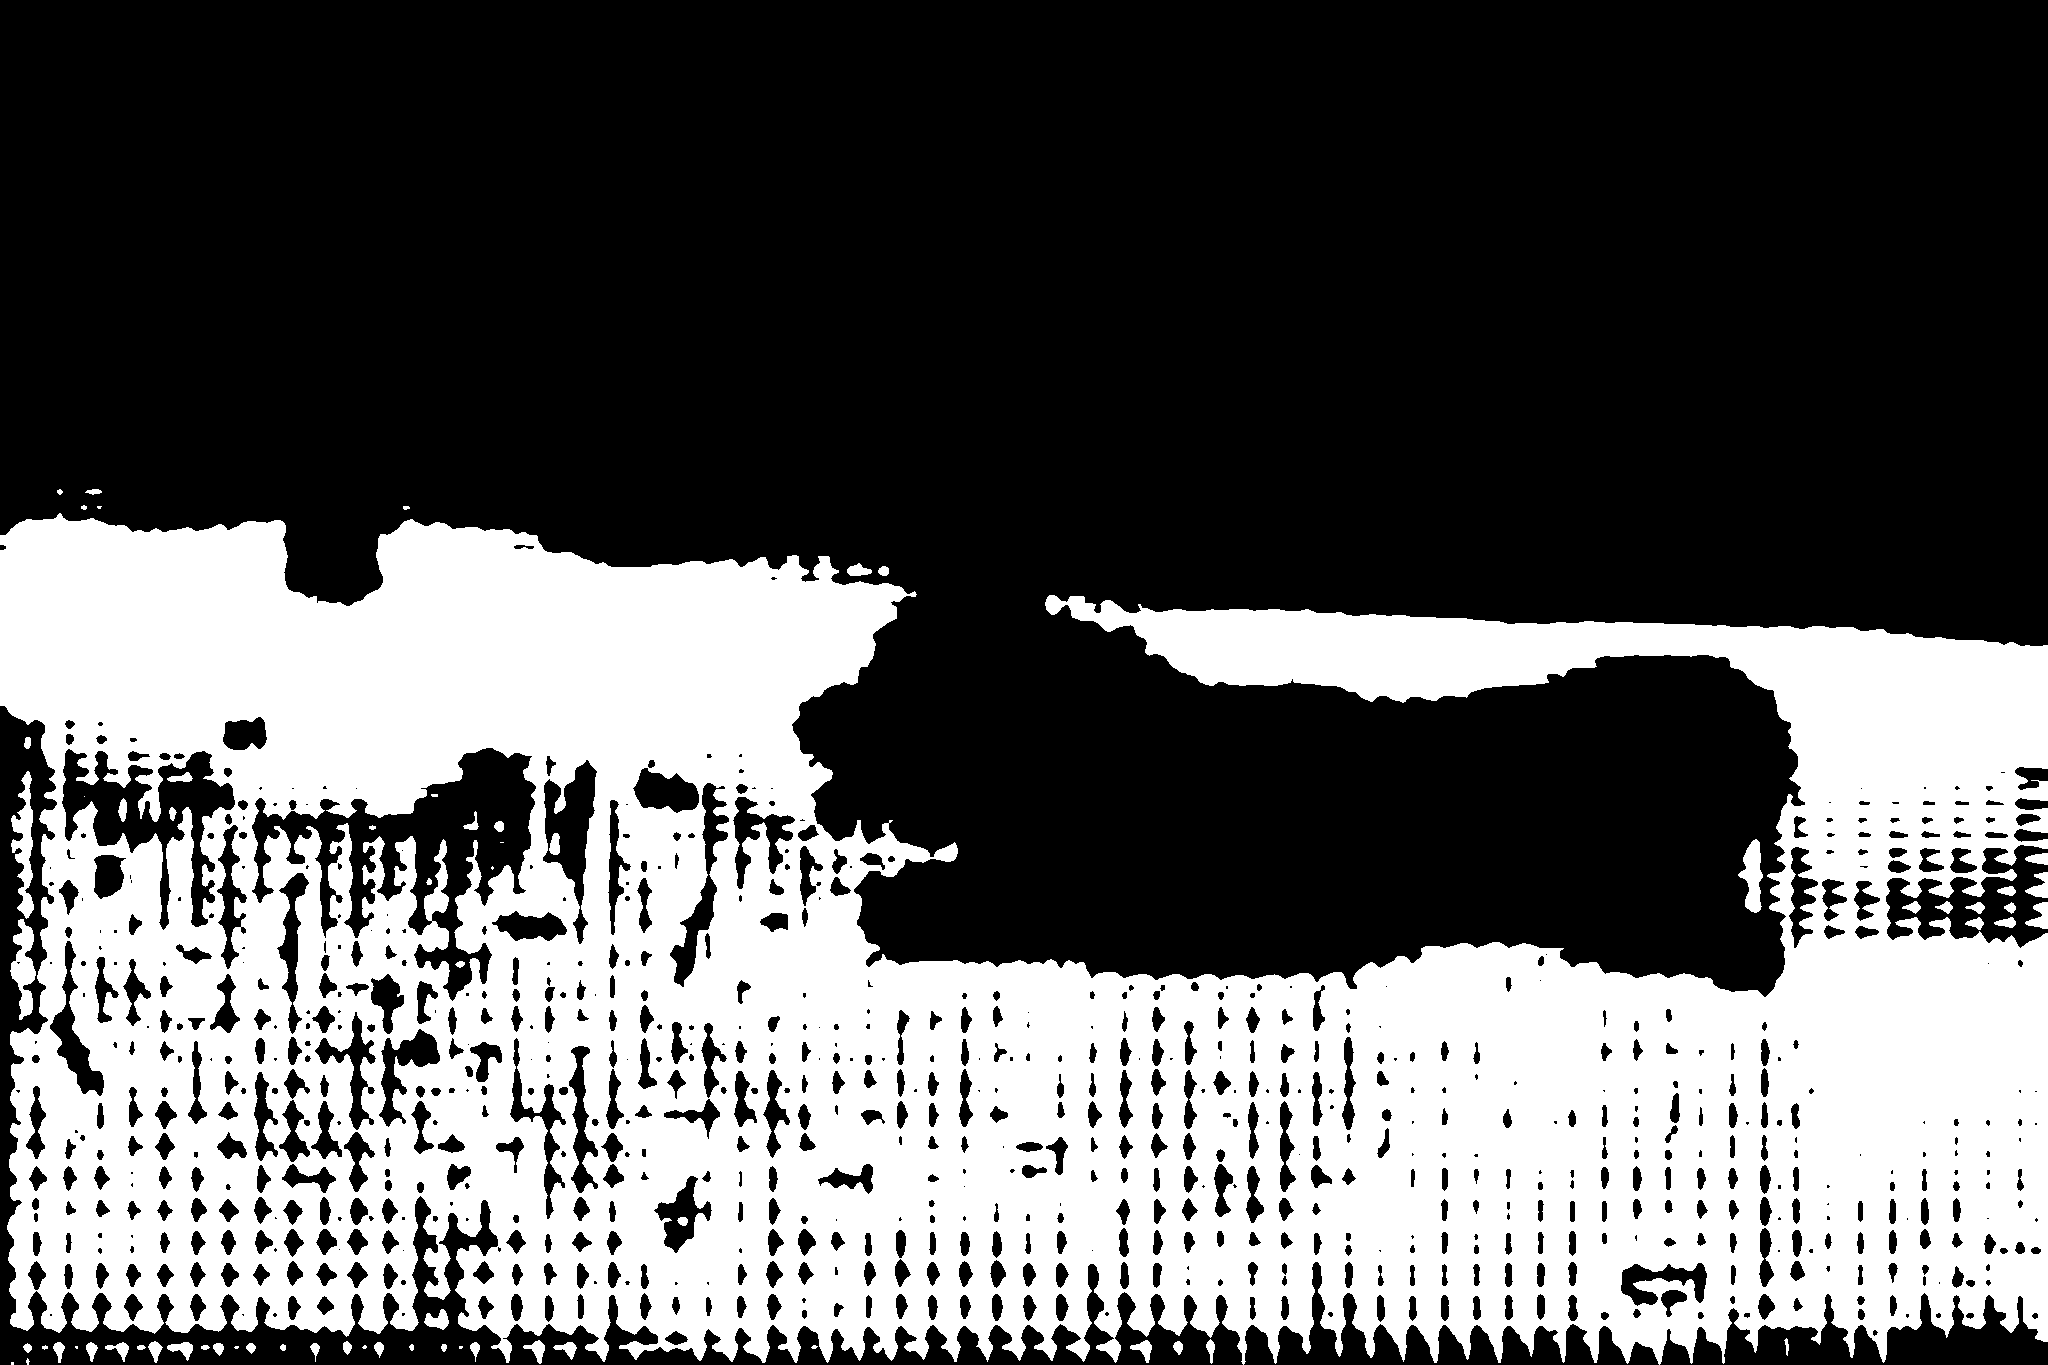

In [22]:
fst,snd,thrd = results[0]["segmentation"],results[1]["segmentation"],results[2]["segmentation"]
Image.fromarray(thrd) 

In [10]:
def put_massk(image,mask):
    img = image.copy()
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j] == 1:
                img[i,j] = [255,0,0]
    return img




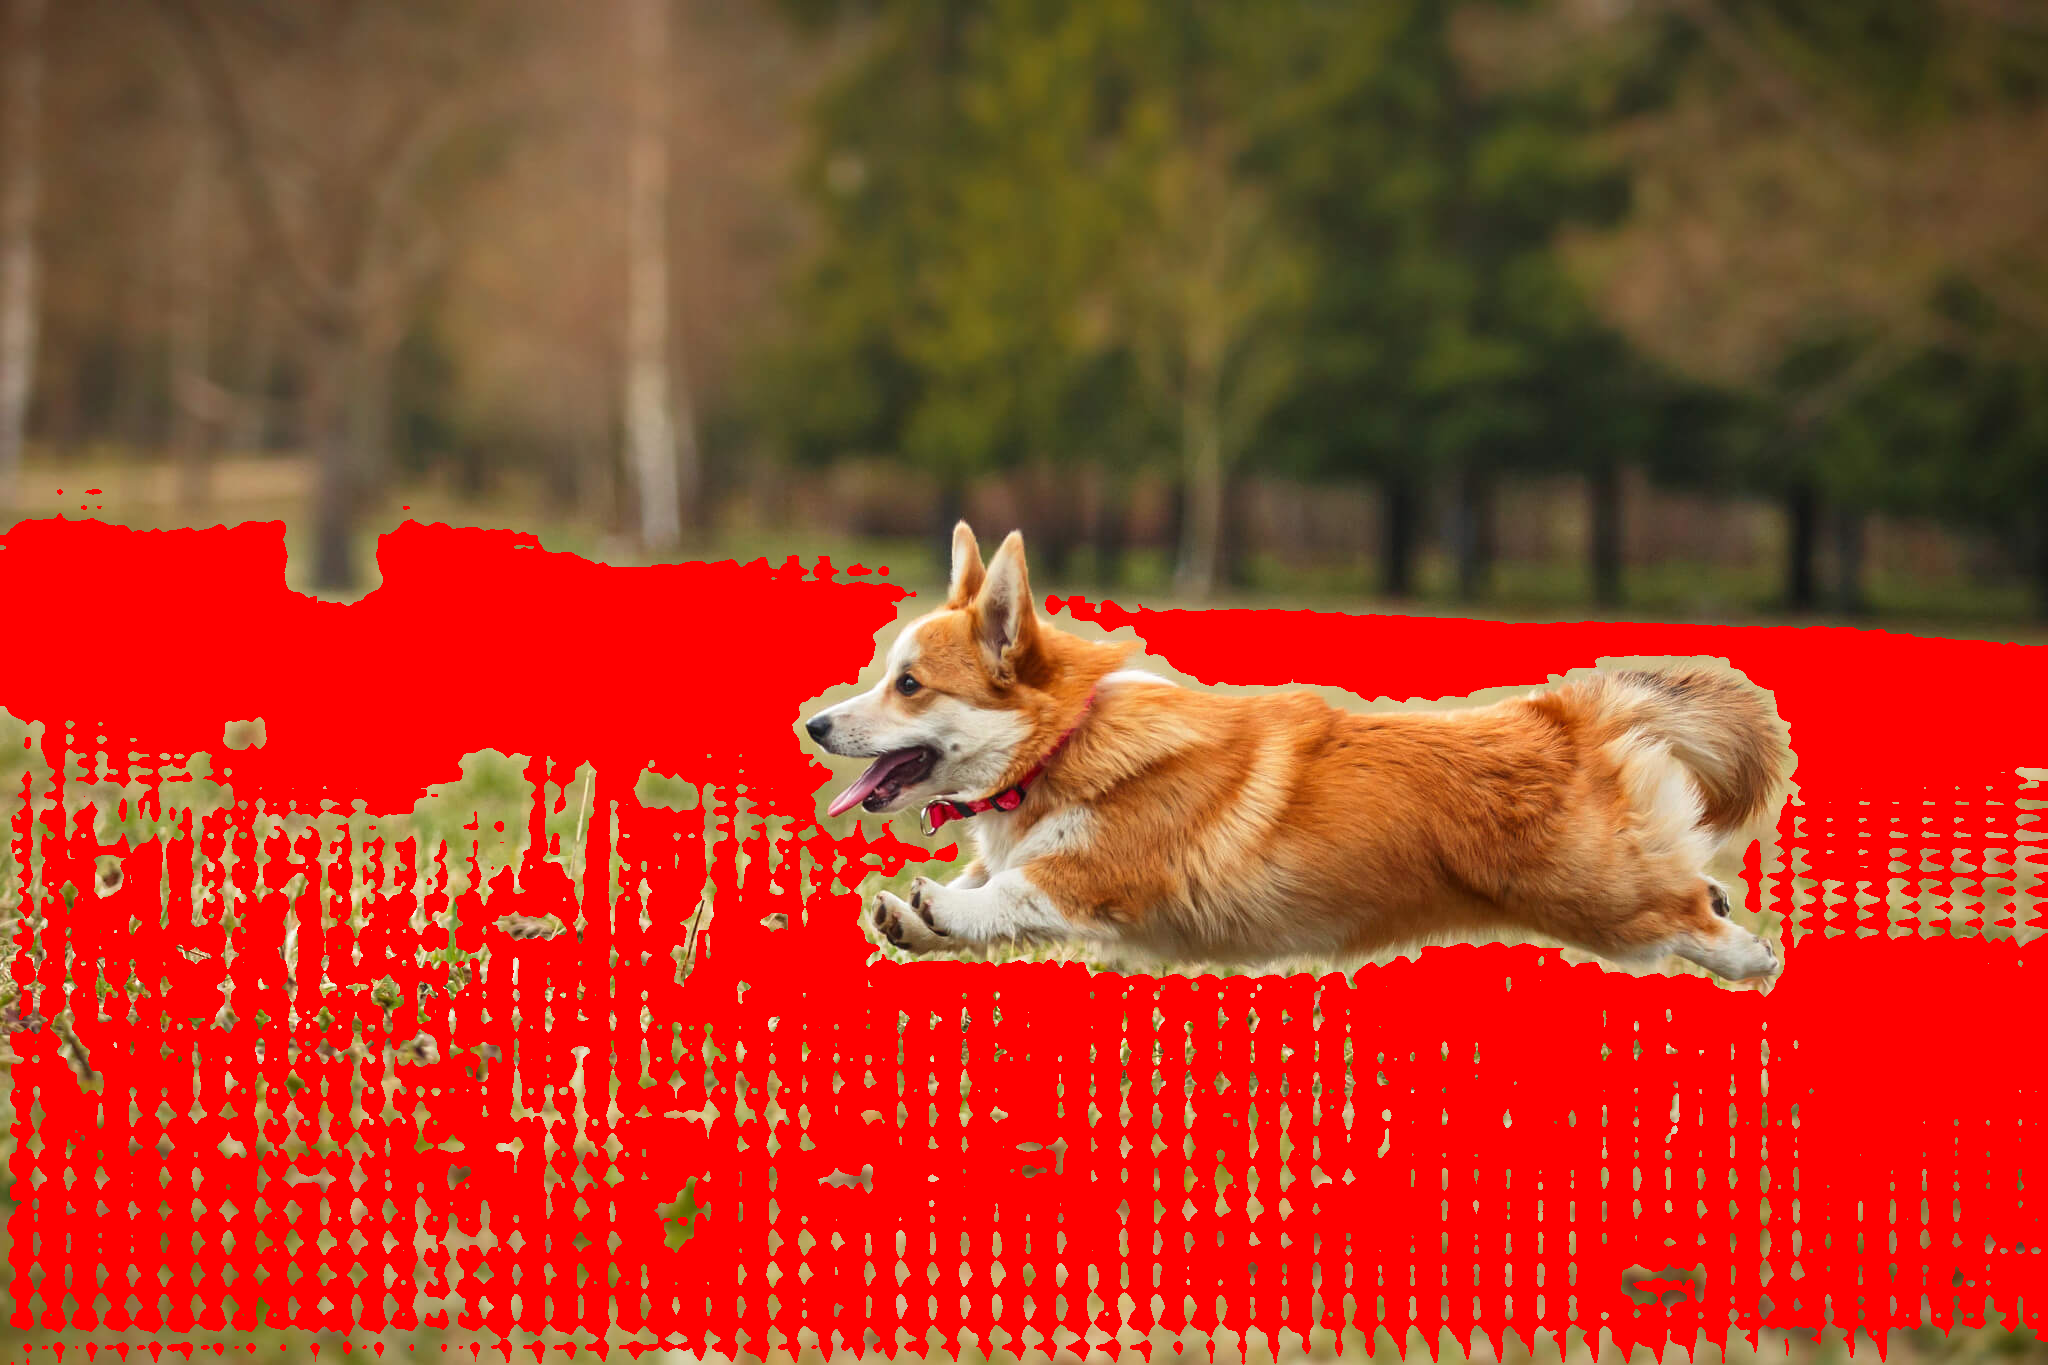

In [25]:
Image.fromarray(put_massk(image,thrd))